<a href="https://colab.research.google.com/github/RomanaNourin/Hacking-The-Fender/blob/main/HBD_CNN%2BGRU_hybrid(0_001).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.15


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2

# Base directory containing the dataset (Train and Test folders)
base_dir = '/content/drive/MyDrive/Human Behavior dataset (HBD21)/Enhanced_test&train_data'

# Directory where frames will be saved
output_dir = '/content/drive/MyDrive/Human Behavior dataset (HBD21)'

# Number of frames to extract from each video (you can set this to None if you want all frames)
frames_per_video = 30

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to extract frames from a video and save them as images
def extract_frames(video_path, output_folder, frames_to_extract=None):
    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total number of frames
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))  # Get the frame rate of the video

    # Calculate interval for extracting frames (if specified)
    if frames_to_extract:
        interval = max(1, frame_count // frames_to_extract)
    else:
        interval = 1  # Extract all frames

    # Loop to read frames
    count = 0
    extracted_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        # Save frame at the specified interval
        if count % interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{count:05d}.jpg")
            cv2.imwrite(frame_filename, frame)
            extracted_count += 1

        count += 1
        # Stop if we've extracted the specified number of frames
        if frames_to_extract and extracted_count >= frames_to_extract:
            break

    cap.release()

# Loop through Train and Test folders
for dataset_type in ['Train', 'Test']:
    dataset_dir = os.path.join(base_dir, dataset_type)

    # Loop through each class/category folder in the dataset (e.g., Abuse, Arrest, etc.)
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)

        # Check if the current item is a directory
        if not os.path.isdir(class_dir):
            continue

        # Loop through all video files in the current class folder
        for video_file in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video_file)

            # Skip non-video files (if any)
            if not video_file.endswith(('.mp4', '.avi', '.mov', '.mkv')):
                continue

            # Create a folder for each video under the correct class in the output directory
            output_class_dir = os.path.join(output_dir, dataset_type, class_name)
            if not os.path.exists(output_class_dir):
                os.makedirs(output_class_dir)

            # Create a folder specific to this video within the class folder
            video_name = os.path.splitext(video_file)[0]
            output_video_dir = os.path.join(output_class_dir, video_name)
            if not os.path.exists(output_video_dir):
                os.makedirs(output_video_dir)

            # Extract frames from the video and save them
            extract_frames(video_path, output_video_dir, frames_per_video)

print("Frames extraction with labels complete!")


Frames extraction with labels complete!


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import pickle
from tqdm import tqdm
import numpy as np
import random

In [5]:
test_dir = '/content/drive/MyDrive/Human Behavior dataset (HBD21)/Train'
train_dir = '/content/drive/MyDrive/Human Behavior dataset (HBD21)/Test'

In [6]:
# Define the categories and labels
categories_labels = {'assault_violence': 0, 'gun_violence': 1, 'normal_actions': 2, 'sabotage_violence': 3}

In [7]:
import os
import cv2
from tqdm import tqdm

def load_data(base_dir, categories_labels):
    data = []

    # Go through each category
    for category, label in categories_labels.items():
        # The path to the category directory
        category_dir = os.path.join(base_dir, category)
        print(f"Checking category directory: {category_dir}")  # Debugging print

        # Make sure the directory exists
        if os.path.isdir(category_dir):
            # Go through each subfolder (video name) in the category directory
            for video_subfolder in os.listdir(category_dir):
                video_subfolder_path = os.path.join(category_dir, video_subfolder)
                print(f"  Checking video subfolder: {video_subfolder_path}")  # Debugging print

                # Ensure it's a directory (subfolder)
                if os.path.isdir(video_subfolder_path):
                    # Go through each image in the video subfolder
                    for filename in os.listdir(video_subfolder_path):
                        # Make sure the file is an image
                        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
                            # The path to the image
                            image_path = os.path.join(video_subfolder_path, filename)
                            print(f"    Found image: {image_path}")  # Debugging print

                            try:
                                # Load the image
                                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                                # Check if the image was loaded successfully
                                if image is None:
                                    print(f"Error: Could not read image {image_path}")
                                    continue

                                # Resize the image
                                image = cv2.resize(image, (128, 128))

                                # Reshape the image to a 4D array (ImageDataGenerator requires 4D array)
                                image = image.reshape((1,) + image.shape + (1,))

                                # Add the image and its label to the data
                                data.append([image, label])
                            except Exception as e:
                                print(f"Error processing image {image_path}: {e}")

        else:
            print(f"Category directory {category_dir} does not exist!")  # Debugging print

    return data

# Directories where the data is stored
train_dir = '/content/drive/MyDrive/Human Behavior dataset (HBD21)/Train'
test_dir = '/content/drive/MyDrive/Human Behavior dataset (HBD21)/Test'

# Category labels (You can replace this with your actual category labels)
categories_labels = {'assault_violence': 0, 'gun_violence': 1, 'normal_actions': 2, 'sabotage_violence': 3}
# Load the training and test data
training_data = load_data(train_dir, categories_labels)
test_data = load_data(test_dir, categories_labels)

# Combine the training and test data
total_data = training_data + test_data

print(f"Loaded {len(total_data)} images.")


Streaming output truncated to the last 5000 lines.
    Found image: /content/drive/MyDrive/Human Behavior dataset (HBD21)/Train/sabotage_violence/sabotage_violence (55)/frame_00234.jpg
    Found image: /content/drive/MyDrive/Human Behavior dataset (HBD21)/Train/sabotage_violence/sabotage_violence (55)/frame_00243.jpg
    Found image: /content/drive/MyDrive/Human Behavior dataset (HBD21)/Train/sabotage_violence/sabotage_violence (55)/frame_00252.jpg
    Found image: /content/drive/MyDrive/Human Behavior dataset (HBD21)/Train/sabotage_violence/sabotage_violence (55)/frame_00261.jpg
  Checking video subfolder: /content/drive/MyDrive/Human Behavior dataset (HBD21)/Train/sabotage_violence/sabotage_violence (56)
    Found image: /content/drive/MyDrive/Human Behavior dataset (HBD21)/Train/sabotage_violence/sabotage_violence (56)/frame_00000.jpg
    Found image: /content/drive/MyDrive/Human Behavior dataset (HBD21)/Train/sabotage_violence/sabotage_violence (56)/frame_00009.jpg
    Found image:

In [8]:
len(total_data)


13890

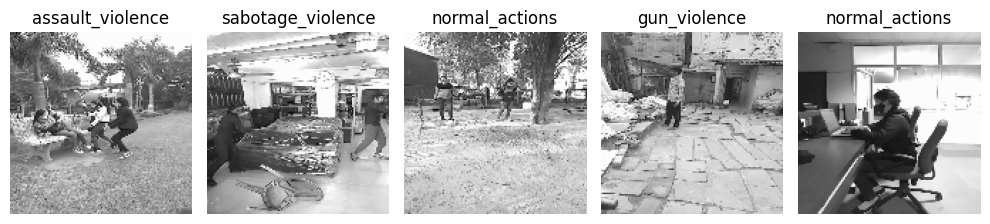

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_images(data, categories_labels, num_samples=5):
    # Reverse the categories_labels dictionary to map labels back to category names
    labels_to_categories = {v: k for k, v in categories_labels.items()}

    plt.figure(figsize=(10, 10))

    # Randomly select a few images to display
    indices = np.random.choice(len(data), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image, label = data[idx]

        # Reshape the image to display correctly (50x50 in your case)
        image = image.reshape(128, 128)

        # Get the corresponding category name for the label
        category_name = labels_to_categories[label]

        # Display the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(category_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you have a dictionary 'categories_labels'
# e.g., categories_labels = {'Abuse': 0, 'Arrest': 1, 'Arson': 2, ...}

# Display 5 sample images from total_data with their categorical labels
show_sample_images(total_data, categories_labels, num_samples=5)


In [10]:
!sudo pip install keras
!pip install np_utils
!pip install pydot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56437 sha256=b85e99ec38426198c19138deefe701b5b3a3dca78b422cb42087e87bd38abdee
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import GRU
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from keras.layers import LSTM, TimeDistributed, Conv1D, MaxPooling1D
from keras.layers import Dense, Dropout, Flatten
from keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.callbacks import ModelCheckpoint, CSVLogger
import time


# Initialize lists to store the images and the labels
images = []
labels = []

# Go through each image and its label in the total_data
for image, label in total_data:
    images.append(image)
    labels.append(label)

# Convert the lists into numpy arrays
images = np.array(images)
labels = np.array(labels)
print(images.shape)

# Reshape images for LSTM
images_gru = images.reshape(images.shape[0], 128*128, 1)  # Added third dimension for features

# Set a seed for reproducibility
seed = 42

# Split the data into training and testing sets for CNN
train_images_cnn, test_images_cnn, train_labels_cnn, test_labels_cnn = train_test_split(images, labels, test_size=0.2, random_state=seed)

# Split the data into training and testing sets for LSTM
train_images_gru, test_images_gru, train_labels_gru, test_labels_gru = train_test_split(images_gru, labels, test_size=0.2, random_state=seed)

# Convert labels to categorical for CNN
train_labels_cnn = np_utils.to_categorical(train_labels_cnn, len(categories_labels))
test_labels_cnn = np_utils.to_categorical(test_labels_cnn, len(categories_labels))

# Convert labels to categorical for LSTM
train_labels_gru = np_utils.to_categorical(train_labels_gru, len(categories_labels))
test_labels_gru = np_utils.to_categorical(test_labels_gru, len(categories_labels))

# Remove the second dimension from data
train_images_cnn = np.squeeze(train_images_cnn, axis=1)
test_images_cnn = np.squeeze(test_images_cnn, axis=1)


# CNN Model
model_CNN = Sequential()
model_CNN.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=(128, 128, 1)))
model_CNN.add(LeakyReLU(alpha=0.1))
model_CNN.add(MaxPooling2D((2, 2), padding='same'))
model_CNN.add(Dropout(0.25))
model_CNN.add(Conv2D(128, (3, 3), padding='same'))
model_CNN.add(LeakyReLU(alpha=0.1))
model_CNN.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_CNN.add(Dropout(0.25))
model_CNN.add(Conv2D(256, (3, 3), padding='same'))
model_CNN.add(LeakyReLU(alpha=0.1))
model_CNN.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_CNN.add(Dropout(0.4))
model_CNN.add(Flatten())
model_CNN.add(Dense(256))
model_CNN.add(LeakyReLU(alpha=0.1))
model_CNN.add(Dropout(0.5))

# GRU Model
model_gru = Sequential()
model_gru.add(GRU(units=8, return_sequences=True, input_shape=(16384, 1), activation='tanh'))
model_gru.add(GRU(units=8, return_sequences=True))
model_gru.add(Dense(4, activation='tanh'))
model_gru.add(Dropout(0.2))
model_gru.add(Flatten())




# Combine CNN and LSTM model
nb_classes = 4
combined = concatenate([model_CNN.output, model_gru.output], axis=-1)
output = Dense(nb_classes, activation='softmax')(combined)
model_final = Model(inputs=[model_CNN.input, model_gru.input], outputs=output)

# Plot and compile the model
plot_model(model_final, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# model_final.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import Callback

class HybridOptimizer(Callback):
    def __init__(self, sgd, adam, switch_epoch):
        super(HybridOptimizer, self).__init__()
        self.sgd = sgd
        self.adam = adam
        self.switch_epoch = switch_epoch

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.switch_epoch:
            print(f"Epoch {epoch + 1}: Using Adam optimizer")
            self.model.optimizer = self.adam
        else:
            print(f"Epoch {epoch + 1}: Switching to SGD optimizer")
            self.model.optimizer = self.sgd

# Initialize optimizers
adam = Adam(learning_rate=0.001)
sgd = SGD(learning_rate=0.001, momentum=0.9)

# Use Adam for the first 10 epochs, then switch to SGD
switch_epoch = 10

# Initialize hybrid optimizer callback
hybrid_optimizer_callback = HybridOptimizer(sgd, adam, switch_epoch)

# Compile model (initially with Adam or any optimizer)
model_final.compile(loss='categorical_crossentropy',
                    optimizer=adam,
                    metrics=['accuracy'])
# Callbacks
csv_logger = CSVLogger('training_alexnet.log', separator=',', append=False)
mc = ModelCheckpoint('CNN_AlexNet.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# Train with the hybrid optimizer
history = model_final.fit([train_images_cnn, train_images_gru], train_labels_gru,
                          batch_size=64, epochs=20,
                          validation_data=([test_images_cnn, test_images_gru], test_labels_gru),
                          callbacks=[hybrid_optimizer_callback, mc, csv_logger])




# Training
time1 = time.time()
history = model_final.fit([train_images_cnn, train_images_gru], train_labels_gru, batch_size=64, epochs=20, validation_data=([test_images_cnn, test_images_gru], test_labels_gru), callbacks=[mc, csv_logger])
print(("Training time=", time.time()-time1))

# Save training history
np.save("Model.npy", history.history)


(13890, 1, 128, 128, 1)
Epoch 1: Using Adam optimizer
Epoch 1/20
174/174 [==============================] - ETA: 0s - loss: 5.1324 - accuracy: 0.5319
Epoch 00001: val_loss improved from inf to 17.04858, saving model to CNN_AlexNet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


174/174 [==============================] - 161s 865ms/step - loss: 5.1324 - accuracy: 0.5319 - val_loss: 17.0486 - val_accuracy: 0.4550
Epoch 2: Using Adam optimizer
Epoch 2/20
174/174 [==============================] - ETA: 0s - loss: 0.3652 - accuracy: 0.8814
Epoch 00002: val_loss did not improve from 17.04858
174/174 [==============================] - 145s 834ms/step - loss: 0.3652 - accuracy: 0.8814 - val_loss: 22.4354 - val_accuracy: 0.5115
Epoch 3: Using Adam optimizer
Epoch 3/20
174/174 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.9656
Epoch 00003: val_loss did not improve from 17.04858
174/174 [==============================] - 145s 837ms/step - loss: 0.1274 - accuracy: 0.9656 - val_loss: 19.9345 - val_accuracy: 0.6447
Epoch 4: Using Adam optimizer
Epoch 4/20
174/174 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9835
Epoch 00004: val_loss improved from 17.04858 to 11.26566, saving model to CNN_AlexNet.h5
174/174 [============

In [ ]:

# Step 1: Convert one-hot encoded labels back to class indices
train_class_labels_cnn = np.argmax(train_labels_cnn, axis=1)
test_class_labels_cnn = np.argmax(test_labels_cnn, axis=1)

train_class_labels_lstm = np.argmax(train_labels_gru, axis=1)
test_class_labels_lstm = np.argmax(test_labels_gru, axis=1)

# Step 2: Count the number of images in each class for both training and test sets
def count_images_per_class(class_labels, num_classes):
    return {f'Class {i}': np.sum(class_labels == i) for i in range(num_classes)}

# Define the number of classes based on categories_labels length
num_classes = len(categories_labels)

# CNN: Count images in each class for training and testing sets
cnn_train_class_counts = count_images_per_class(train_class_labels_cnn, num_classes)
cnn_test_class_counts = count_images_per_class(test_class_labels_cnn, num_classes)

# LSTM: Count images in each class for training and testing sets
lstm_train_class_counts = count_images_per_class(train_class_labels_lstm, num_classes)
lstm_test_class_counts = count_images_per_class(test_class_labels_lstm, num_classes)

# Print results
print("CNN Training Set Image Counts:", cnn_train_class_counts)
print("CNN Testing Set Image Counts:", cnn_test_class_counts)
print("GRU Training Set Image Counts:", lstm_train_class_counts)
print("GRU Testing Set Image Counts:", lstm_test_class_counts)


CNN Training Set Image Counts: {'Class 0': 2454, 'Class 1': 3469, 'Class 2': 2613, 'Class 3': 2576}
CNN Testing Set Image Counts: {'Class 0': 636, 'Class 1': 851, 'Class 2': 627, 'Class 3': 664}
LSTM Training Set Image Counts: {'Class 0': 2454, 'Class 1': 3469, 'Class 2': 2613, 'Class 3': 2576}
LSTM Testing Set Image Counts: {'Class 0': 636, 'Class 1': 851, 'Class 2': 627, 'Class 3': 664}


In [ ]:
from keras.models import load_model
fashion_model = load_model('/content/CNN_AlexNet.h5') # load model
fashion_model.summary() # summarize model.

from contextlib import redirect_stdout
with open('/content/CNN_AlexNet.h5'+".xls", 'w') as f:
    with redirect_stdout(f):
        fashion_model.summary()

val_loss, val_accuracy=fashion_model.evaluate([test_images_cnn, test_images_lstm] ,test_labels_cnn) ## to get test accuracy and losses
print(val_loss, val_accuracy)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_6_input (InputLayer  [(None, 128, 128, 1)]        0         []                            
 )                                                                                                
                                                                                                  
 conv2d_6 (Conv2D)           (None, 128, 128, 64)         640       ['conv2d_6_input[0][0]']      
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)   (None, 128, 128, 64)         0         ['conv2d_6[0][0]']            
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 64)           0         ['leaky_re_lu_8[0][0]'] 

In [ ]:
import time
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import jaccard_score, cohen_kappa_score, matthews_corrcoef

# Start the timer for classification
time2 = time.time()

# Predict probabilities for both CNN and LSTM test images
predict_prob = fashion_model.predict([test_images_cnn, test_images_gru])

# Convert predicted probabilities to class labels
y_pred = np.argmax(predict_prob, axis=1)

# Classification time
print('Classification time:', time.time() - time2)

# Ground truth (actual) labels
y_true = np.argmax(test_labels_cnn, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification Report
print('Classification Report:')
print(classification_report(y_true, y_pred))

# Precision, Recall, F1 Score (weighted)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 Score: %f' % f1)

# IoU (Jaccard Score)
iou = jaccard_score(y_true, y_pred, average='micro')
print('IoU (Jaccard Index):', iou)

# Cohen's Kappa Score
kappa = cohen_kappa_score(y_true, y_pred)
print('Cohen\'s Kappa: %f' % kappa)

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)
print('Matthews Correlation Coefficient (MCC): %f' % mcc)

# Model evaluation on test set
test_eval = fashion_model.evaluate([test_images_cnn, test_images_gru], test_labels_cnn)
print('Test Loss:', test_eval[0])
print('Test Accuracy:', test_eval[1])

# Model evaluation on training set
loss_train, accuracy_train = fashion_model.evaluate([train_images_cnn, train_images_gru], train_labels_cnn)
print('Train Loss:', loss_train, 'Train Accuracy:', accuracy_train)


87/87 [==============================] - 27s 302ms/step
Classification time: 27.255484342575073
Confusion Matrix:
[[621   5   1   9]
 [  2 848   1   0]
 [  1   0 626   0]
 [ 12   0   1 651]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       636
           1       0.99      1.00      1.00       851
           2       1.00      1.00      1.00       627
           3       0.99      0.98      0.98       664

    accuracy                           0.99      2778
   macro avg       0.99      0.99      0.99      2778
weighted avg       0.99      0.99      0.99      2778

Precision: 0.988469
Recall: 0.988481
F1 Score: 0.988472
IoU (Jaccard Index): 0.9772241992882562
Cohen's Kappa: 0.984551
Matthews Correlation Coefficient (MCC): 0.984553
87/87 [==============================] - 27s 308ms/step - loss: 0.0531 - accuracy: 0.9885
Test Loss: 0.05308150500059128
Test Accuracy: 0.9884809255599976
348/348 [==================

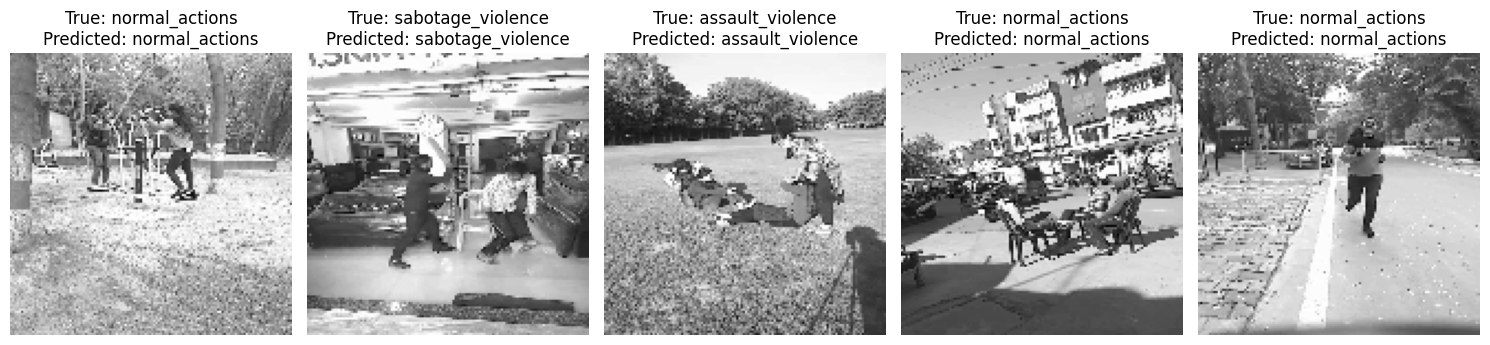

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_validation_images(test_images_cnn, test_images_lstm, y_true, y_pred, categories_labels, num_samples=5):
    # Reverse the categories_labels dictionary to map labels back to category names
    labels_to_categories = {v: k for k, v in categories_labels.items()}

    plt.figure(figsize=(15, 15))

    # Randomly select a few images to display
    indices = np.random.choice(len(test_images_cnn), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image = test_images_cnn[idx]

        # Get the true and predicted labels
        true_label = labels_to_categories[y_true[idx]]
        predicted_label = labels_to_categories[y_pred[idx]]

        # Reshape the image to display correctly (50x50 in your case)
        image = image.reshape(128, 128)

        # Display the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming y_true and y_pred are already calculated
y_true = np.argmax(test_labels_cnn, axis=1)  # Convert one-hot encoded labels to class integers

# Display 5 validation images with their true and predicted labels
show_validation_images(test_images_cnn, test_images_lstm, y_true, y_pred, categories_labels, num_samples=5)


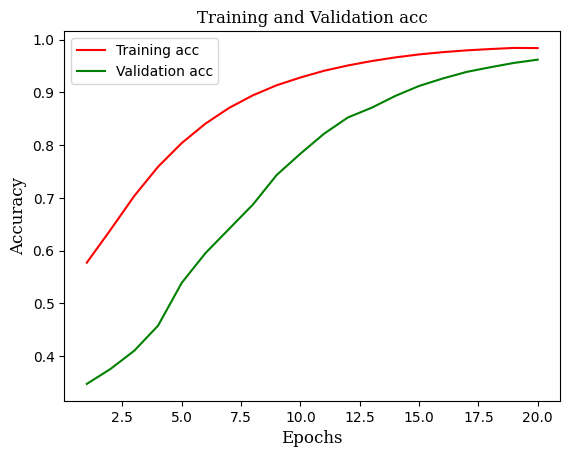

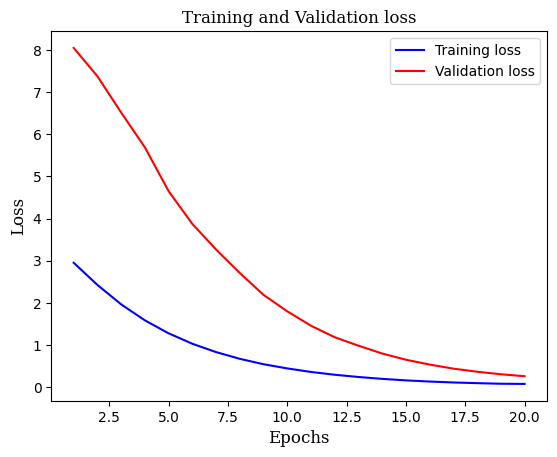

In [ ]:
import matplotlib.pyplot as plt

history_dict=history.history
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
acc_values=history_dict['accuracy']
val_acc_values=history_dict['val_accuracy']
epochs=range(1, len(acc_values)+1)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
loss_values=smooth_curve(loss_values)
val_loss_values=smooth_curve(val_loss_values)
acc_values=smooth_curve(acc_values)
val_acc_values=smooth_curve(val_acc_values)

font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12}


plt.plot(epochs, acc_values, 'r-', label='Training acc')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc')
plt.title('Training and Validation acc', fontdict=font)
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.legend()
plt.savefig("accuracy"+'CNN_AlexNet'+".png")
plt.show()

plt.plot(epochs, loss_values, 'b-', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation loss', fontdict=font)
plt.xlabel('Epochs',fontdict=font)
plt.ylabel('Loss',fontdict=font)
plt.legend()
plt.savefig("loss"+'Model'+".png")
plt.show()

Confusion matrix, without normalization
[[621   5   1   9]
 [  2 848   1   0]
 [  1   0 626   0]
 [ 12   0   1 651]]


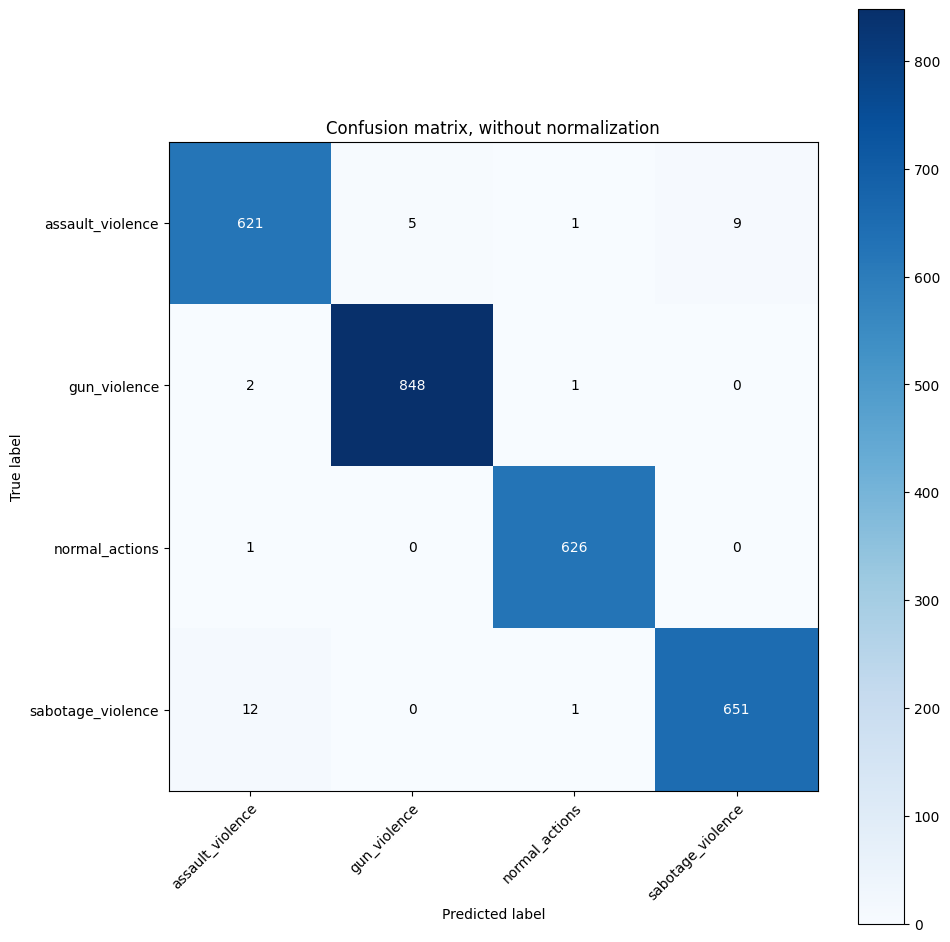

Normalized confusion matrix
[[0.98 0.01 0.   0.01]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.02 0.   0.   0.98]]


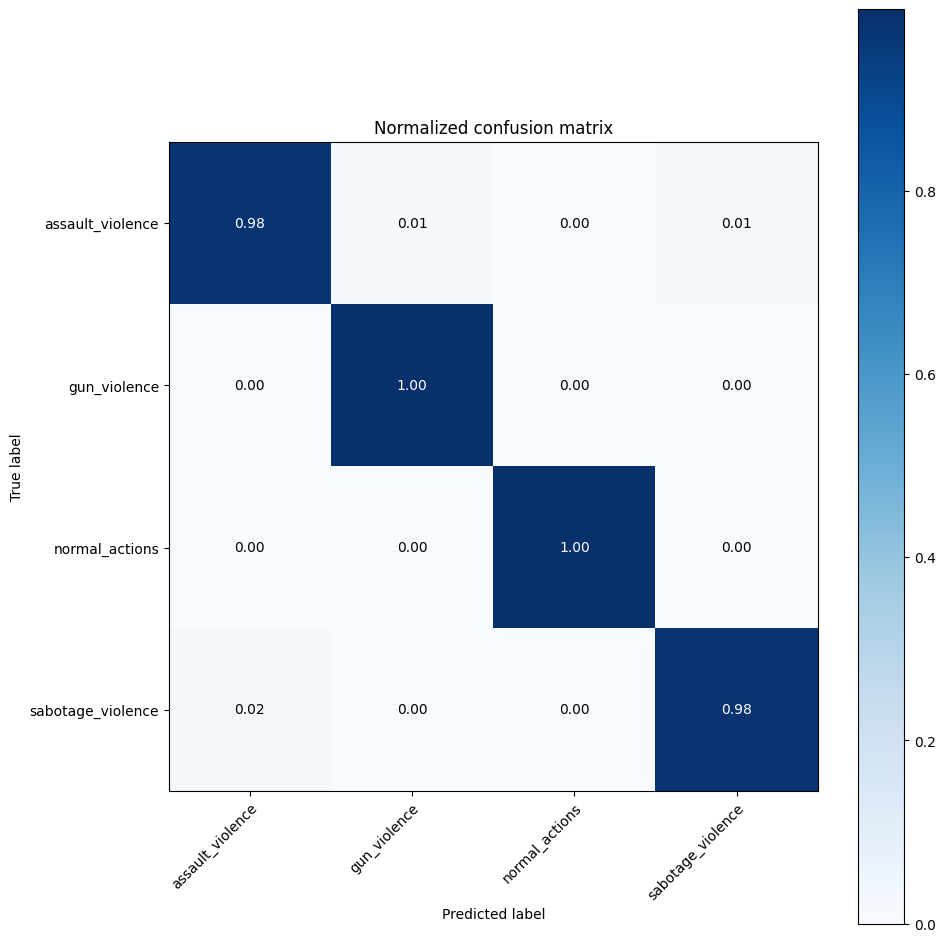

In [ ]:
class_names = ['assault_violence', 'gun_violence', 'normal_actions', 'sabotage_violence']


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 14}
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig('confusion matrix1'+'CNN_AlexNet'+'.png')
plt.show()
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('confusion matrix2'+'CNN_AlexNet'+'.png')
plt.show()

87/87 [==============================] - 26s 303ms/step
Classification time: 26.67889404296875
[[621   5   1   9]
 [  2 848   1   0]
 [  1   0 626   0]
 [ 12   0   1 651]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       636
           1       0.99      1.00      1.00       851
           2       1.00      1.00      1.00       627
           3       0.99      0.98      0.98       664

    accuracy                           0.99      2778
   macro avg       0.99      0.99      0.99      2778
weighted avg       0.99      0.99      0.99      2778

Precision: 0.988469
Recall: 0.988481
F1 score: 0.988472
IoU: 0.9772241992882562
348/348 [==============================] - 106s 305ms/step - loss: 0.0124 - accuracy: 0.9960
Train loss: 0.01237341109663248 Train accuracy: 0.9959503412246704
Test loss: 0.05308150500059128 Test accuracy: 0.9884809255599976


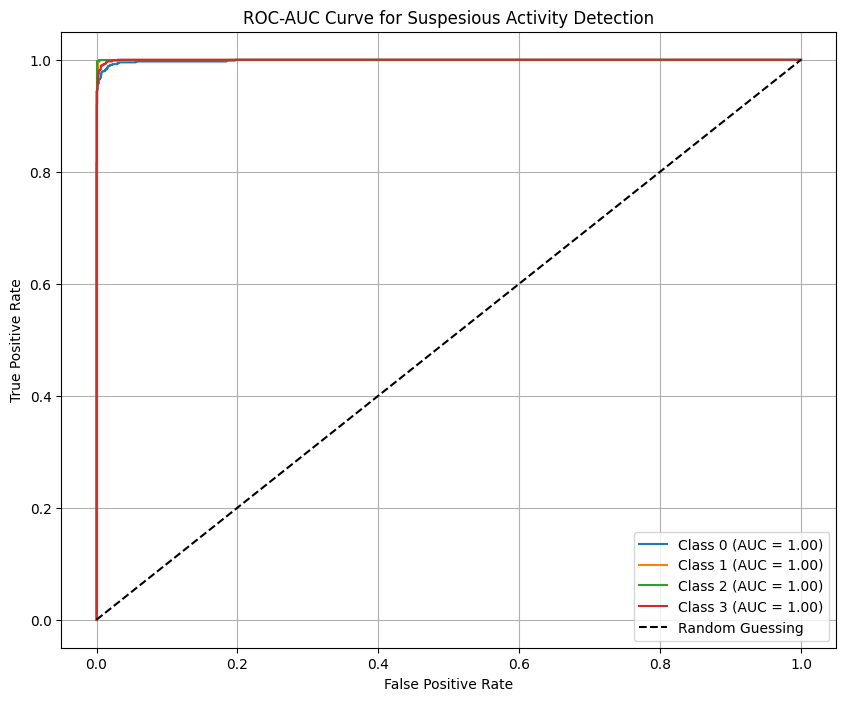

Micro-average AUC: 1.00
Macro-average AUC: 1.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_score, recall_score, f1_score, jaccard_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Timing the predictions
time2 = time.time()
predict_prob = fashion_model.predict([test_images_cnn, test_images_gru])
y_pred = np.argmax(predict_prob, axis=1)
print('Classification time:', time.time() - time2)

# True labels
y_true = np.argmax(test_labels_cnn, axis=1)

# Classification metrics
cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred))

# Precision, recall, F1
precision = precision_score(y_true, y_pred, average='weighted')
print('Precision: %f' % precision)
recall = recall_score(y_true, y_pred, average='weighted')
print('Recall: %f' % recall)
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 score: %f' % f1)

# Intersection over Union (IoU)
print('IoU:', jaccard_score(y_true, y_pred, average='micro'))

# Model evaluation
test_eval = fashion_model.evaluate([test_images_cnn, test_images_gru], test_labels_cnn)
loss, accuracy = fashion_model.evaluate([train_images_cnn, train_images_gru], train_labels_cnn)
print('Train loss:', loss, 'Train accuracy:', accuracy)
print('Test loss:', test_eval[0], 'Test accuracy:', test_eval[1])

# --------- ROC-AUC Curve ---------

# Step 1: Binarize the true labels for the one-vs-rest approach
n_classes = len(np.unique(y_true))  # Total number of classes
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Step 2: Calculate ROC curve and AUC for each class
fpr = dict()  # False Positive Rate for each class
tpr = dict()  # True Positive Rate for each class
roc_auc = dict()  # AUC for each class

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predict_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 3: Plot the ROC curve for each class with AUC
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Customize the plot
plt.title('ROC-AUC Curve for Suspesious Activity Detection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

# Step 4: Show the plot
plt.show()

# Step 5: Calculate and print overall AUC score (micro and macro average)
micro_roc_auc = roc_auc_score(y_true_bin, predict_prob, average='micro')
macro_roc_auc = roc_auc_score(y_true_bin, predict_prob, average='macro')

print(f'Micro-average AUC: {micro_roc_auc:.2f}')
print(f'Macro-average AUC: {macro_roc_auc:.2f}')
